In [367]:
from niagara import Chain, Model, ModelIntrinsicLogProb, NullTransformation, LogisticRegressionCalibrator
from niagara import OpenAIClient, FireworksClient, OneSidedAsymptoticLog, TwoSidedAsymptoticLog
import pickle

llama_chain = Chain(
    models = [
        Model(
            model_name=name, 
            thresholds={"reject": -10000, "accept": 0.0},
            conf_signal=ModelIntrinsicLogProb(),
            conf_signal_transform=NullTransformation(),
            conf_signal_calibrator=LogisticRegressionCalibrator()
        )
        for name in ["llama3.2-1b", "llama3.2-3b", "llama3.1-8b", "llama3.1-70b", "llama3.1-405b"]
    ]
)

qwen_oai_chain = Chain(
    models = [
        Model(
            model_name=name, 
            thresholds={"reject": -10000, "accept": 0.0},
            conf_signal=ModelIntrinsicLogProb(),
            conf_signal_transform=NullTransformation(),
            conf_signal_calibrator=LogisticRegressionCalibrator(),
            client=client
        )
        for name, client in [("gpt-4o-mini", OpenAIClient()), ("qwen2.5-32b-coder-instruct", FireworksClient()), ("qwen2.5-72b-instruct", FireworksClient()), ("gpt-4o", OpenAIClient())]
    ]
)

NAME = "mmlu"
CHAIN_NAME = "llama_chain"
ALL_MODEL_INDICES = [
    [0, 1],
    [0, 2],
    [1, 2],
    [0, 1, 2],
    [0, 3],
    [1, 3],
    [2, 3],
    [0, 1, 3],
    [0, 2, 3],
    [1, 2, 3],
    [0, 1, 2, 3],
    [0, 4],
    [1, 4],
    [2, 4],
    [3, 4],
    [0, 1, 4],
    [0, 2, 4],
    [0, 3, 4],
    [1, 2, 4],
    [1, 3, 4],
    [2, 3, 4],
    [0, 1, 2, 4],
    [0, 1, 3, 4],
    [0, 2, 3, 4],
    [1, 2, 3, 4],
    [0, 1, 2, 3, 4]
]

TRANSFORM = OneSidedAsymptoticLog() if NAME in {'mmlu', 'medmcqa'} else TwoSidedAsymptoticLog()

if CHAIN_NAME == "llama_chain":
    CHAIN = llama_chain
elif CHAIN_NAME == "qwen_oai_chain":
    CHAIN = qwen_oai_chain

# Update the transformation for the chain
for model in CHAIN.models:
    model.conf_signal_transform = TRANSFORM

with open(f'../benchmarks/data/{NAME}/chain_results/{NAME}_full_{CHAIN_NAME}_results_train.pkl', 'rb') as f:
    results_train = pickle.load(f)
with open(f'../benchmarks/data/{NAME}/chain_results/{NAME}_full_{CHAIN_NAME}_results_test.pkl', 'rb') as f:
    results_test = pickle.load(f)

# Get the train and test data

### Compute calibrated confidence values

process_scores = lambda scores: sum(scores.values()) >= 20

if NAME=="xsum":
    raw_corr_train = { k: [process_scores(x) for x in v] for k,v in results_train['model_correctness'].items() }
else:
    raw_corr_train= results_train['model_correctness']

raw_conf_train = results_train['raw_confidences']

corr_train = [
    raw_corr_train[model_name] for model_name in CHAIN.model_names
]

transformed_conf_train = [ 
    list(TRANSFORM.transform_confidence_signal(raw_conf_train[model_name]))
        for model_name in CHAIN.model_names
]

calibration_data = [
    {"correctness": corr, "transformed_confidence": conf} 
        for (corr, conf, model_name) 
            in zip(corr_train, transformed_conf_train, CHAIN.model_names)
]

CHAIN.calibrate(calibration_data)

calibrated_conf_train = [
    list(
        CHAIN.models[model_idx].conf_signal_calibrator.calibrate_confidence_signal(
            transformed_conf_train[model_idx]
        )
    )
    for model_idx in range(len(CHAIN.model_names))
]

### Compute test data

if NAME=="xsum":
    raw_corr_test = { k: [process_scores(x) for x in v] for k,v in results_test['model_correctness'].items() }
else:
    raw_corr_test= results_test['model_correctness']

raw_conf_test = results_test['raw_confidences']

corr_test = [
    raw_corr_test[model_name] for model_name in CHAIN.model_names
]

transformed_conf_test = [ 
    list(TRANSFORM.transform_confidence_signal(raw_conf_test[model_name]))
        for model_name in CHAIN.model_names
]

calibrated_conf_test = [
    list(
        CHAIN.models[model_idx].conf_signal_calibrator.calibrate_confidence_signal(
            transformed_conf_test[model_idx]
        )
    )
    for model_idx in range(len(CHAIN.model_names))
]

Optimization terminated successfully.
         Current function value: 0.613777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.501526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344372
         Iterations 7


In [369]:
from scipy.integrate import quad

### Define function for computing area under the curve (AUC)

def compute_auc(x, y, x_min, x_max, integration_limit=200, method='linear'):
    """
    Compute area under the curve of the function y = f(x), as defined by point samples.
    """
    x = np.array(x)
    y = np.array(y)
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    f = interp1d(x, y, kind=method, bounds_error=False, fill_value='extrapolate')
    
    return quad(f, x_min, x_max, limit=integration_limit)


In [370]:
import pandas as pd
import numpy as np
from optimize_cascade import get_expected_uncumulated_costs

raw_model_costs = { 
    model_name: CHAIN.models[i].cpm_tokens 
        for i, model_name in enumerate(CHAIN.model_names) 
}

expected_uncumulated_costs_train = get_expected_uncumulated_costs(raw_model_costs, results_train)
expected_uncumulated_costs_test = get_expected_uncumulated_costs(raw_model_costs, results_test)

def compute_utilization_from_conditional_deferral_probs(conditional_deferral_probs):
    return [
        np.prod(conditional_deferral_probs[:i]) * (1 - conditional_deferral_probs[i])
            for i in range(0,len(conditional_deferral_probs))
    ]

def compute_utilization_and_error(T, model_indices, calibrated_conf_train, conditional_deferral_probs=None):
    """ Estimate the probabilities that each model return the query. """
    # use local indices for accessing calibrated confidences of the selected models
    cal_conf_tr = np.array(calibrated_conf_train).transpose()[:, model_indices]

    utilizations = []
    conditional_corrs = []
    unconditional_corrs = []

    # add utilization of the first model
    first_model_accepts = cal_conf_tr[:, 0] > T[0]
    utilizations.append(np.mean(first_model_accepts))
    conditional_corrs.append(np.mean(cal_conf_tr[first_model_accepts, 0]))
    unconditional_corrs.append(np.mean(cal_conf_tr[:,0]))

    # get utilizations for the second and subsequent models
    for i in range(1, len(model_indices)):
        prior_models_delegate = np.all(cal_conf_tr[:,:i] <= np.array(T)[np.newaxis, :i], axis=1)
        this_model_accepts = (cal_conf_tr[:,i] > T[i]) if i < len(model_indices)-1 else np.array([True])

        # utilization rate
        utilization = np.mean(prior_models_delegate & this_model_accepts)
        utilizations.append(utilization)

        # error conditioned on returning the query
        conditional_corr = np.mean(cal_conf_tr[prior_models_delegate & this_model_accepts,i])
        conditional_corrs.append(conditional_corr)

        # unconditional error
        unconditional_corr = np.mean(cal_conf_tr[:,i])
        unconditional_corrs.append(unconditional_corr)

    if conditional_deferral_probs is not None:
        utilizations = compute_utilization_from_conditional_deferral_probs(conditional_deferral_probs)
    
    # print(f"Utilization: {utilizations}\nConditional Errors:{conditional_corrs}")
    return utilizations, conditional_corrs, unconditional_corrs


def get_ecorr_ecost_estimates(threshold_list, model_indices, calibrated_conf_train):
    """ Estimate the expected probability of correctness and expected cost for all thresholds. """
    outputs = []

    for i in range(len(threshold_list)):
        T = threshold_list[i]

        util, cond_corr, uncond_corr = compute_utilization_and_error(T, model_indices, calibrated_conf_train)
        costs = np.array(expected_uncumulated_costs_train)[model_indices]

        ecorr_estimate = np.nansum(np.array(util) * np.array(cond_corr))
        ecost_estimate = np.nansum(np.array(util) * np.cumsum(costs))

        outputs.append((ecost_estimate, ecorr_estimate))
    
    return outputs

In [ ]:
### Setup for getting the probabilistic model
import os
import pickle
from time import time
from itertools import product
from paretoset import paretoset
from optimize_cascade import train_probability_model

def get_optimal_thresholds_using_grid_search(model_indices, data_train, quantile_h = 0.025, eps=0.01):
    """ Get optimal thresholds via grid search. """
    # Compute the grid for each threshold
    threshold_grids = [ np.quantile(data_train[idx], q=np.arange(0+eps,1-eps,quantile_h)) for idx in model_indices[:-1] ]

    # Get all candidates
    threshold_candidates = [ np.array(x) for x in product(*threshold_grids) ]

    # Get cost and correctness for candidates
    ecost_ecorr = get_ecorr_ecost_estimates(threshold_candidates, model_indices, data_train)

    # Compute the Pareto set of solutions
    df = pd.DataFrame(ecost_ecorr, columns=['expected_cost','expected_correctness'])
    pareto_mask = paretoset(df, sense=["min", "max"])
    pareto_df = df.loc[pareto_mask]

    # Return the Pareto solutions AND the optimal thresholds
    opt_tholds = [ threshold_candidates[i] for i in range(len(pareto_mask)) if pareto_mask[i] ]
    return pareto_df, opt_tholds

start = time()
filename = f"data/probabilistic_model_results_{NAME}.pkl"
SAVE_TO_FILE = False

if os.path.exists(filename):
    with open(filename, 'rb') as file:
        prob_results = pickle.load(file)
else:
    prob_results = train_probability_model(full_data=np.array(calibrated_conf_train).transpose())
    if SAVE_TO_FILE:
        with open(filename, 'wb') as file:
            pickle.dump(prob_results, file)

stop = time()
print(stop-start)

In [377]:
import numpy as np

def fill_parameter_gaps_adaptively(parameters_list, model_indices, data_train, max_prob_gap=0.1):
    """
    Fill gaps between parameters by adding midpoints when probability mass gap is too large.
    
    Args:
        parameters_list: List of parameter vectors (numpy arrays)
        model_indices: Indices to select relevant columns from data_train
        data_train: Training data array (n_obs x n_features)
        max_prob_gap: Maximum allowed probability mass between consecutive parameters
        
    Returns:
        List of parameters including added midpoints
    """
    # Return early if we have 0 or 1 parameters
    if len(parameters_list) <= 1:
        return parameters_list
        
    # Convert to numpy array for easier manipulation
    params_list = np.array(parameters_list)
    
    # Get the observed values
    observed_values = np.array([data_train[i] for i in model_indices[:-1]]).transpose()
    
    while True:
        added_point = False
        
        # Look through consecutive pairs
        for i in range(len(params_list)-1):
            # For each component of the parameter vector
            max_prob = 0
            for j in range(params_list.shape[1]):
                # Get values between this pair of parameters for this component
                lower = min(params_list[i][j], params_list[i+1][j])
                upper = max(params_list[i][j], params_list[i+1][j])
                
                # Calculate probability mass between the parameters
                prob_mass = np.mean((observed_values[:, j] > lower) & 
                                  (observed_values[:, j] < upper))
                max_prob = max(max_prob, prob_mass)
            
            if max_prob > max_prob_gap:
                # Calculate midpoint
                midpoint = (params_list[i] + params_list[i+1]) / 2
                
                # Insert midpoint
                params_list = np.insert(params_list, i+1, midpoint, axis=0)
                added_point = True
                break  # Start over since we modified the array
        
        # If we didn't add any points, we're done
        if not added_point:
            break
    
    return [np.array(x) for x in params_list.tolist()]

100%|██████████| 4/4 [00:00<00:00, 157.45it/s]


Continuous optimization took 0.22166109085083008s
Grid search took 0.014301776885986328s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


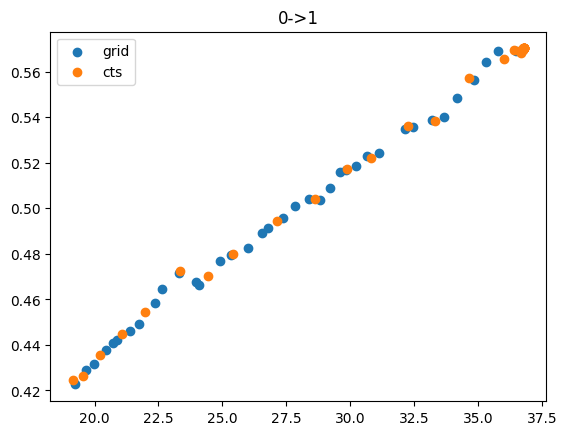

100%|██████████| 4/4 [00:00<00:00, 163.15it/s]


Continuous optimization took 0.19025635719299316s
Grid search took 0.008055448532104492s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


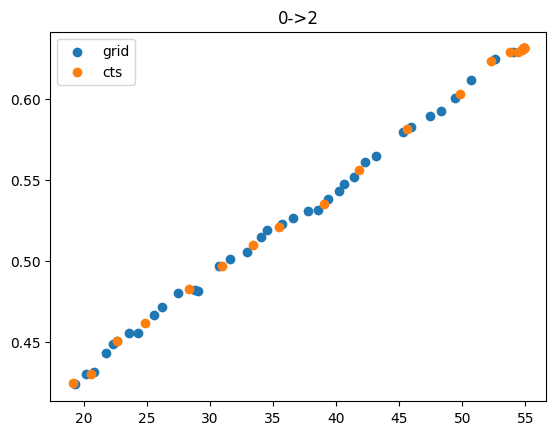

100%|██████████| 4/4 [00:00<00:00, 43.42it/s]]


Continuous optimization took 0.413205623626709s
Grid search took 0.00796818733215332s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


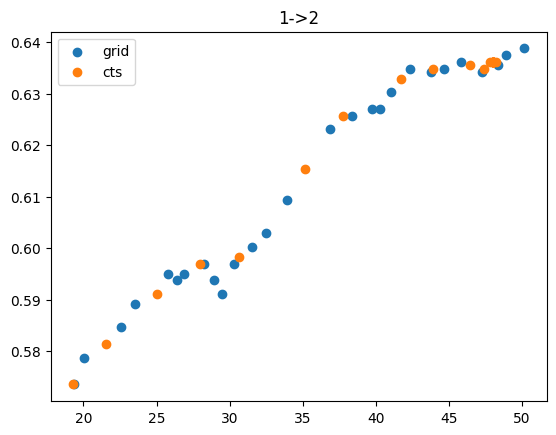

100%|██████████| 4/4 [00:01<00:00,  2.42it/s]]


Continuous optimization took 5.731774806976318s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.36009764671325684s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


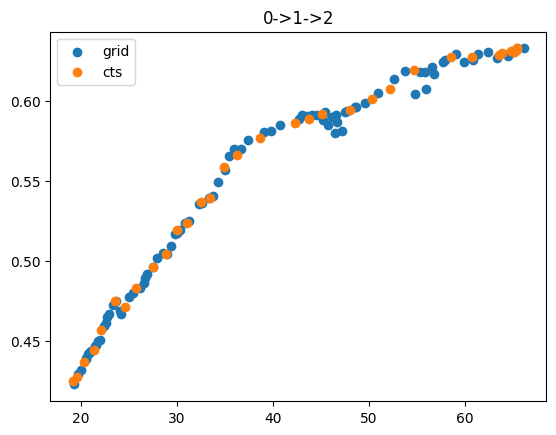

100%|██████████| 4/4 [00:00<00:00, 25.82it/s]]


Continuous optimization took 0.45055127143859863s
Grid search took 0.007900714874267578s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


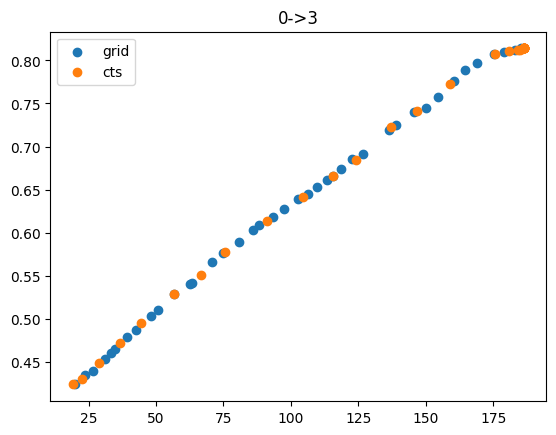

100%|██████████| 4/4 [00:00<00:00, 30.70it/s]]


Continuous optimization took 0.4487447738647461s
Grid search took 0.007811069488525391s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


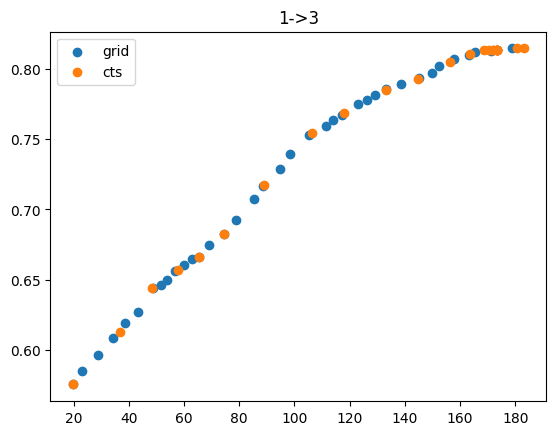

100%|██████████| 4/4 [00:00<00:00, 34.05it/s]]


Continuous optimization took 0.45709228515625s
Grid search took 0.0077342987060546875s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


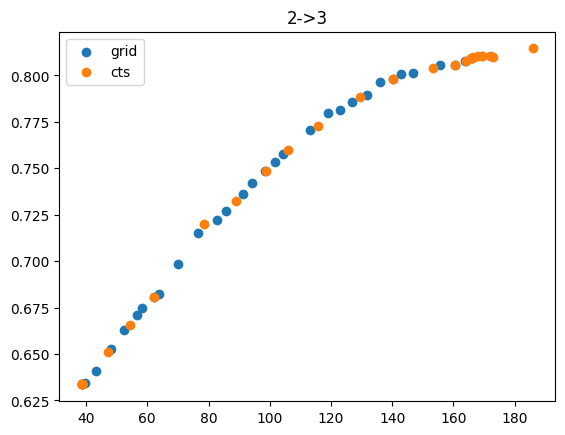

100%|██████████| 4/4 [00:00<00:00,  4.10it/s]]


Continuous optimization took 4.770625829696655s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.346538782119751s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


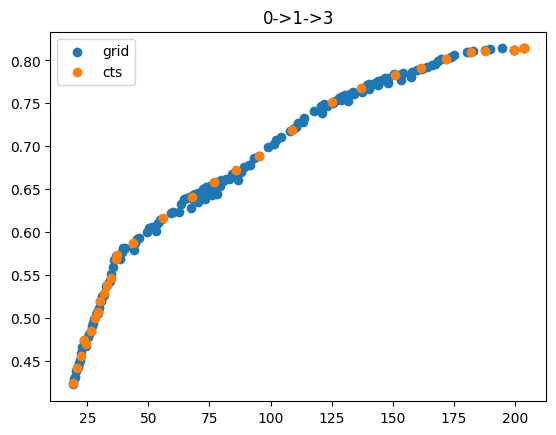

100%|██████████| 4/4 [00:01<00:00,  2.86it/s]]


Continuous optimization took 5.493682384490967s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.331754207611084s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


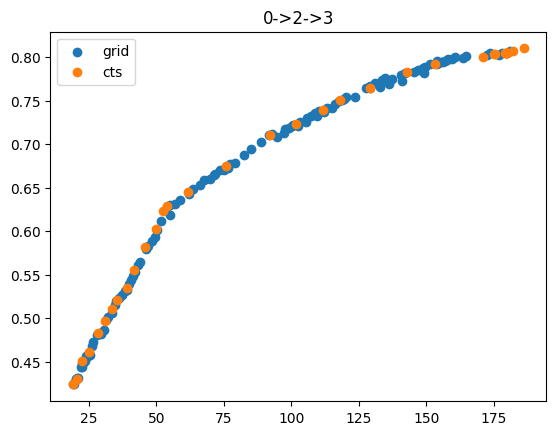

100%|██████████| 4/4 [00:01<00:00,  3.66it/s]]


Continuous optimization took 4.570597410202026s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.3518483638763428s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


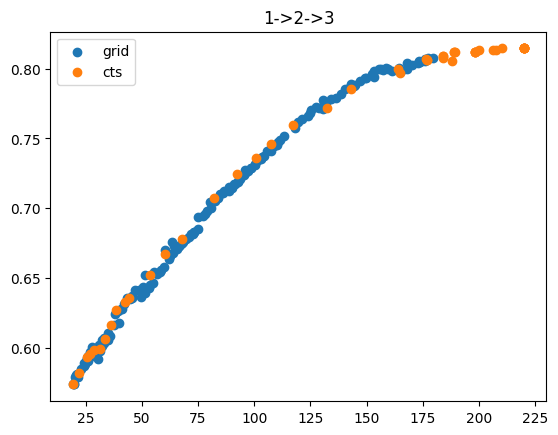

100%|██████████| 4/4 [00:04<00:00,  1.03s/it]t]


Continuous optimization took 17.591630458831787s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 15.04978632926941s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


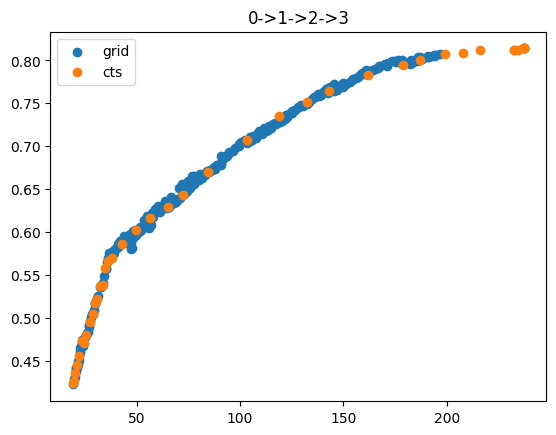

100%|██████████| 4/4 [00:00<00:00, 97.29it/s]t]


Continuous optimization took 0.15204644203186035s
Grid search took 0.007980823516845703s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


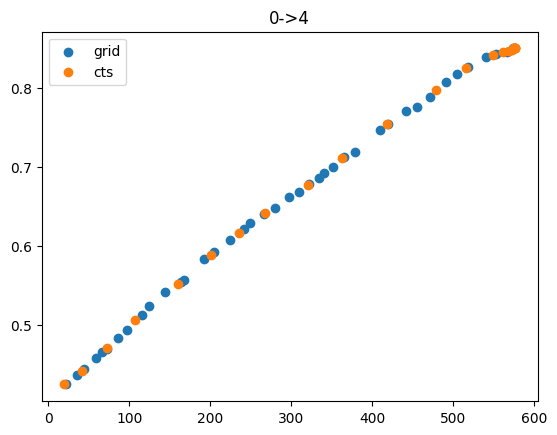

100%|██████████| 4/4 [00:00<00:00, 24.68it/s]t]


Continuous optimization took 0.37750697135925293s
Grid search took 0.007867813110351562s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


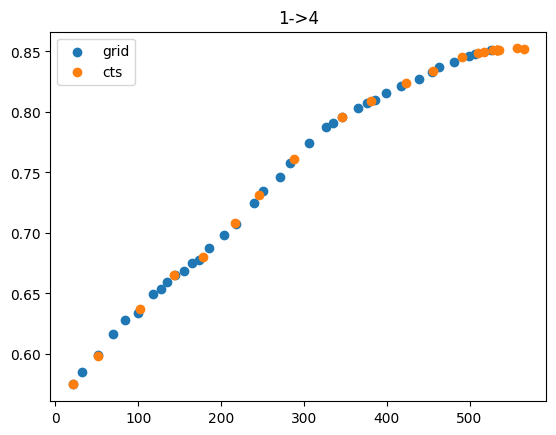

100%|██████████| 4/4 [00:00<00:00, 26.90it/s]t]


Continuous optimization took 0.5059378147125244s
Grid search took 0.007755756378173828s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


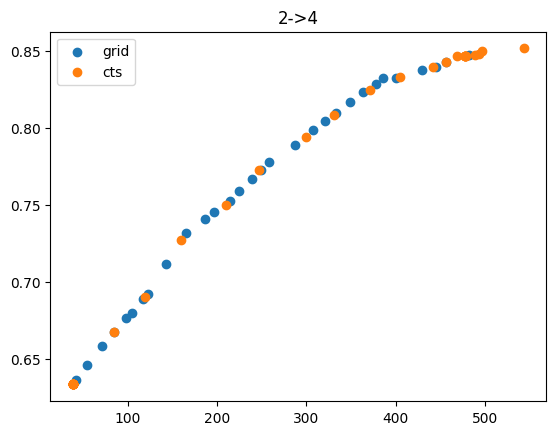

100%|██████████| 4/4 [00:00<00:00, 29.98it/s]t]


Continuous optimization took 0.44443678855895996s
Grid search took 0.007954120635986328s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


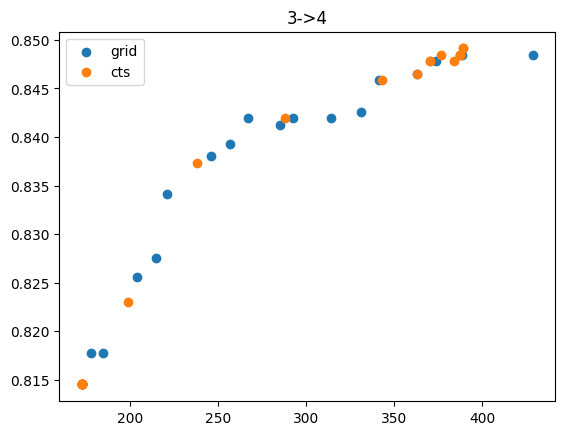

100%|██████████| 4/4 [00:01<00:00,  2.55it/s]t]


Continuous optimization took 4.641242742538452s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.3514559268951416s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


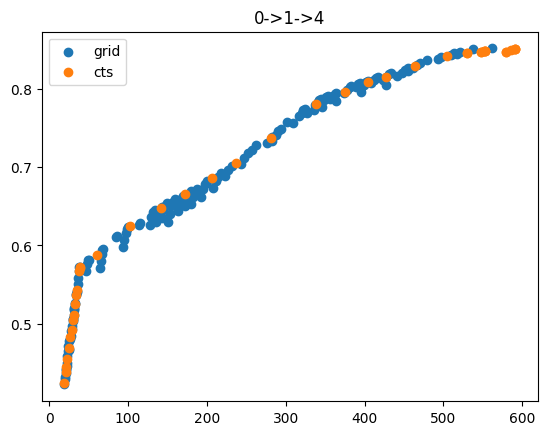

100%|██████████| 4/4 [00:01<00:00,  2.69it/s]t]


Continuous optimization took 5.498522758483887s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.33396458625793457s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


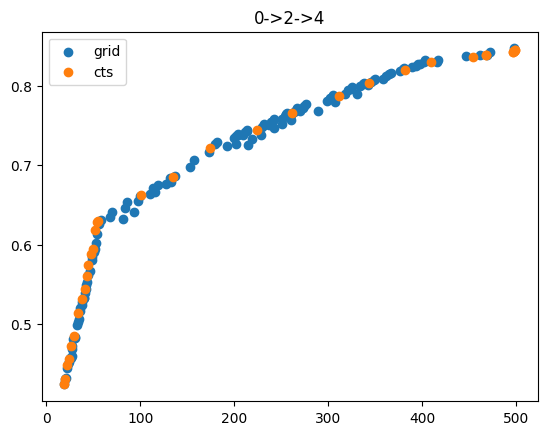

100%|██████████| 4/4 [00:01<00:00,  2.56it/s]t]


Continuous optimization took 4.519155025482178s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.33481526374816895s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


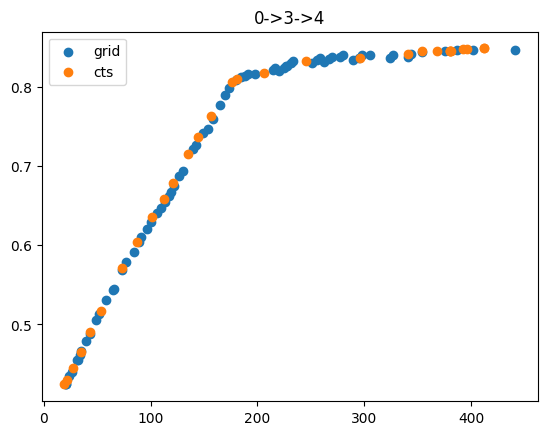

100%|██████████| 4/4 [00:00<00:00,  4.69it/s]t]


Continuous optimization took 4.006953001022339s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.344712495803833s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


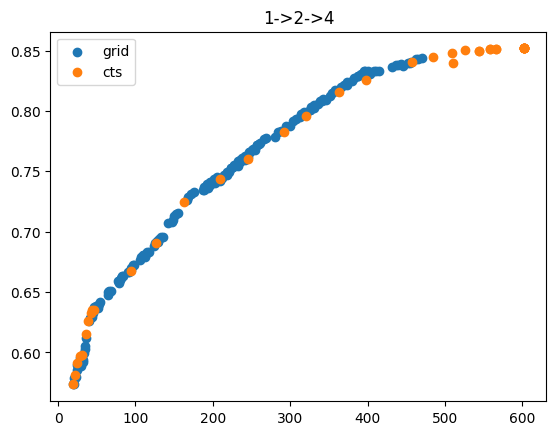

100%|██████████| 4/4 [00:01<00:00,  2.65it/s]t]


Continuous optimization took 4.769161701202393s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.34255409240722656s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


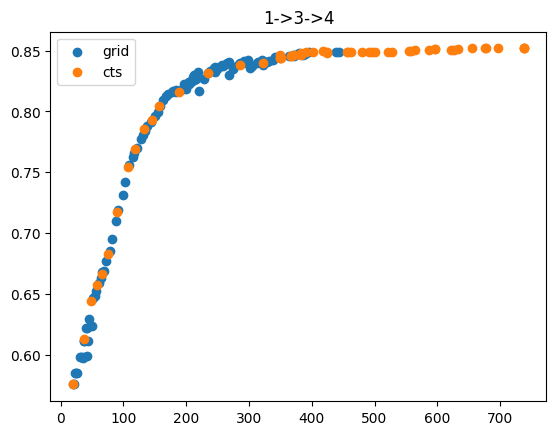

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]t]


Continuous optimization took 4.84726619720459s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.36090970039367676s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)


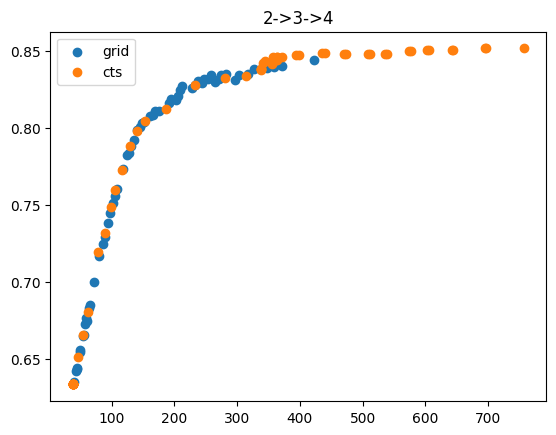

100%|██████████| 4/4 [00:04<00:00,  1.11s/it]t]


Continuous optimization took 17.263968229293823s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 15.016692399978638s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


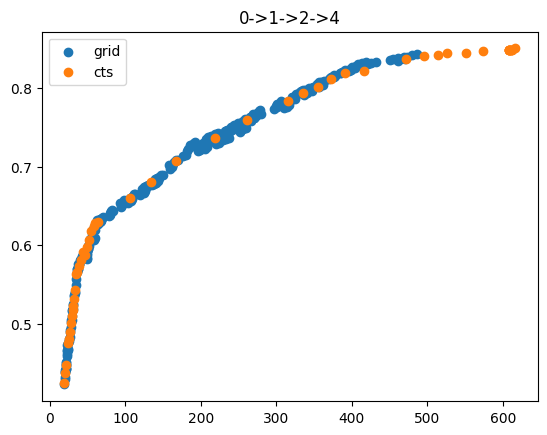

100%|██████████| 4/4 [00:01<00:00,  3.96it/s]t]


Continuous optimization took 11.628030776977539s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.783811092376709s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


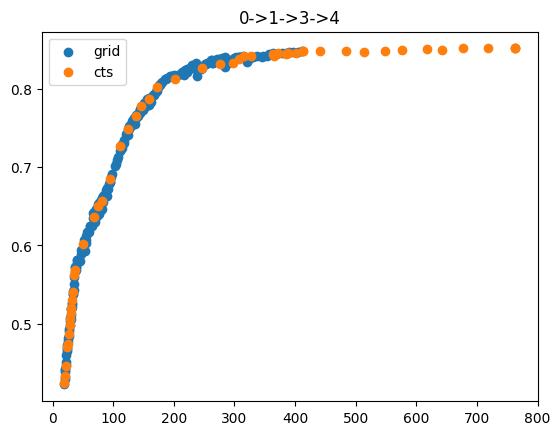

100%|██████████| 4/4 [00:03<00:00,  1.20it/s]t]


Continuous optimization took 14.394863843917847s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.88526439666748s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


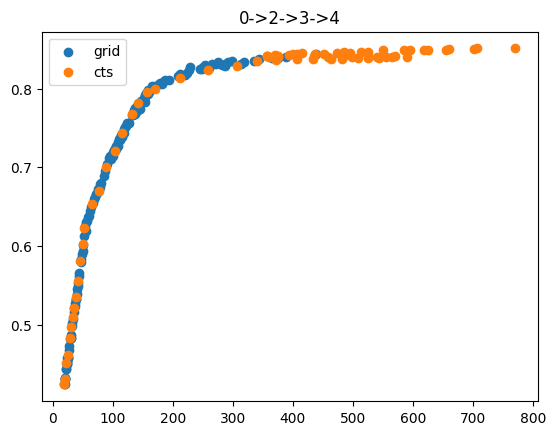

100%|██████████| 4/4 [00:04<00:00,  1.15s/it]t]


Continuous optimization took 15.956811666488647s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 15.001894474029541s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


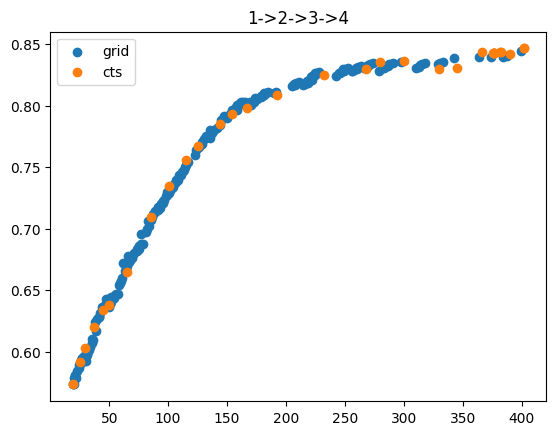

100%|██████████| 4/4 [00:07<00:00,  1.98s/it]t]


Continuous optimization took 22.248677015304565s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 667.5545136928558s


/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, x_min, x_max, limit=integration_limit)
/tmp/ipykernel_2362292/682605517.py:32: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, x_min, x_max, limit=integration_limit)


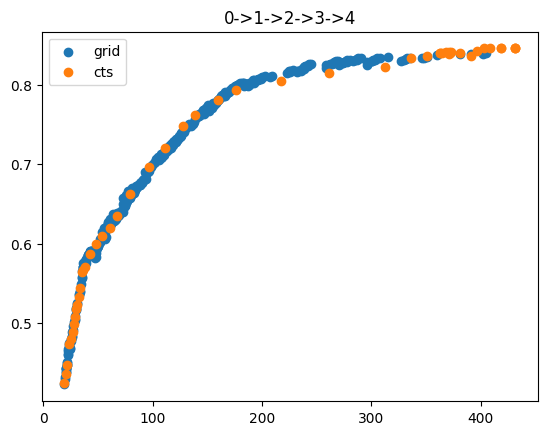

100%|██████████| 26/26 [15:21<00:00, 35.43s/it] 


In [378]:
from optimize_cascade import profile_cascade, profile_cascade_adaptively, make_full_data, score_cascade
from tqdm import tqdm
import matplotlib.pyplot as plt

with open("data/cascade_comparison_records.pkl", "rb") as file:
    ALL_RECORDS = pickle.load(file)

RUN_GRID = True

ALL_RECORDS = []
SAVE_TO_FILE = False

for model_indices in tqdm(ALL_MODEL_INDICES):
    data_train = calibrated_conf_train

    # Optimize the cascade on the data
    start = time()
    cascade_record = profile_cascade_adaptively(
        model_indices, 
        expected_uncumulated_costs_train, 
        prob_results, 
        start_sensitivities=[0, 1e-10, 1e-8, 1e-6], # or did it only go to 1e-7 at first?
        cost_threshold_multiplier=1.25,
        stop_val=1000,
        max_iterations=24, # used to be 100
        sensitivity_increase_factor=2.0 # used to be 2, # used to be 1.2
    )

    opt_tholds_cts_optim = cascade_record['optimal_thresholds']
    opt_tholds_cts_optim = fill_parameter_gaps_adaptively(
        opt_tholds_cts_optim, model_indices, data_train, max_prob_gap=0.1
    )
    stop = time()

    continuous_optim_time = stop-start
    print(f"Continuous optimization took {continuous_optim_time}s")

    # Optimize the thresholds via grid search
    if RUN_GRID:
        quantile_h = 0.025
        start = time()
        pareto_df, opt_tholds_grid_search = get_optimal_thresholds_using_grid_search(model_indices, data_train, quantile_h)
        stop = time()
        grid_search_time = stop-start
        print(f"Grid search took {grid_search_time}s")

    # Score both solutions on the test data
    test_data = {
        'calib_conf': make_full_data(calibrated_conf_test), 
        'corr': make_full_data(corr_test) 
    }

    scores_continuous_optim = [
        score_cascade(T, model_indices, expected_uncumulated_costs_test, test_data)
            for T in opt_tholds_cts_optim #cascade_record['optimal_thresholds']
    ]
    ecost_ecorr_continuous_optim = [ 
        (rec['expected_cost_test'], rec['expected_correctness_test']) for rec in scores_continuous_optim
    ]

    if RUN_GRID:
        scores_grid_search = [
            score_cascade(T, model_indices, expected_uncumulated_costs_test, test_data)
                for T in opt_tholds_grid_search
        ]
        ecost_ecorr_gridsearch = [ (rec['expected_cost_test'], rec['expected_correctness_test']) for rec in scores_grid_search ]

    # Calculate the area under the curve for both methods (make sure to integrate between same min and max cost)
    min_cost_continuous_optim = min(ecost_ecorr_continuous_optim, key= lambda s: s[0])[0]
    max_cost_continuous_optim = max(ecost_ecorr_continuous_optim, key= lambda s: s[0])[0]

    min_cost_gridsearch = min(ecost_ecorr_gridsearch, key= lambda s: s[0])[0]
    max_cost_gridsearch = max(ecost_ecorr_gridsearch, key= lambda s: s[0])[0]

    min_cost_overall = max(min_cost_continuous_optim, min_cost_gridsearch)
    max_cost_overall = min(max_cost_continuous_optim, max_cost_gridsearch)

    auc_cts = compute_auc(*zip(*ecost_ecorr_continuous_optim), x_min=min_cost_overall, x_max=max_cost_overall)[0]
    auc_grid = compute_auc(*zip(*ecost_ecorr_gridsearch), x_min=min_cost_overall, x_max=max_cost_overall)[0]

    # Gather all the results: performance, time, resolution

    record_cts = {
        "benchmark": NAME,
        "cascade": model_indices,
        "cascade_len": len(model_indices),
        "method": "continuous_optimization",
        "performance": auc_cts,
        "auc_bounds": [min_cost_overall, max_cost_overall],
        "auc_norm": 1 - (auc_cts/(max_cost_overall-min_cost_overall)),
        "time": continuous_optim_time,
        "n_grid": len(opt_tholds_cts_optim),
        "data": ecost_ecorr_continuous_optim,
        "scores": scores_continuous_optim,
        "n_obs": len(np.unique(next(zip(*ecost_ecorr_continuous_optim))))
    }

    record_grid = {
        "benchmark": NAME,
        "cascade": model_indices,
        "cascade_len": len(model_indices),
        "method": "gridsearch",
        "performance": auc_grid,
        "auc_bounds": [min_cost_overall, max_cost_overall],
        "auc_norm": 1 - (auc_grid/(max_cost_overall-min_cost_overall)),
        "time": grid_search_time,
        "n_grid": len(opt_tholds_grid_search),
        "data": ecost_ecorr_gridsearch,
        "scores": scores_grid_search,
        "n_obs": len(np.unique(next(zip(*ecost_ecorr_gridsearch))))
    }

    indices_of_these_records = [
        i for i, record in enumerate(ALL_RECORDS) if 
            (record['benchmark'] == NAME) and (record['cascade'] == model_indices)
    ]
    if len(indices_of_these_records) > 0: # check if records already exist; if yes, overwrite
        for idx in indices_of_these_records:
            assert (ALL_RECORDS[idx]['benchmark'] == NAME) and ((ALL_RECORDS[idx]['cascade'] == model_indices))
            if ALL_RECORDS[idx]['method'] == 'gridsearch':
                ALL_RECORDS[idx] = record_grid
            elif ALL_RECORDS[idx]['method'] == 'continuous_optimization':
                ALL_RECORDS[idx] = record_cts
    else: 
        ALL_RECORDS.append(record_cts)
        ALL_RECORDS.append(record_grid)

    plt.figure()
    plt.title("->".join([str(x) for x in model_indices]))
    plt.scatter(*zip(*ecost_ecorr_gridsearch), label='grid')
    plt.scatter(*zip(*ecost_ecorr_continuous_optim), label='cts')
    plt.legend()
    plt.show()


# Save all records to file
if SAVE_TO_FILE:
    with open("data/cascade_comparison_records.pkl", "wb") as file:
        pickle.dump(ALL_RECORDS, file)

In [430]:
from optimize_cascade import profile_cascade, profile_cascade_adaptively, make_full_data, score_cascade
from tqdm import tqdm
import matplotlib.pyplot as plt

GRID_RESOLUTIONS = [ 0.1, 0.05, 0.0333, 0.025, 0.02 ]
SENSITIVITY_INCREASE_FACTORS = [ 3.0, 2.0, 1.5, 1.3, 1.2 ]

ALL_RECORDS = []
SAVE_TO_FILE = False

for model_indices in tqdm(ALL_MODEL_INDICES):
    data_train = calibrated_conf_train

    for sens_increase, grid_h in zip(SENSITIVITY_INCREASE_FACTORS, GRID_RESOLUTIONS):
        max_iter = 24*np.log(2)/np.log(sens_increase)

        # Optimize the cascade on the data
        start = time()
        cascade_record = profile_cascade_adaptively(
            model_indices, 
            expected_uncumulated_costs_train, 
            prob_results, 
            start_sensitivities=[0, 1e-10, 1e-8, 1e-6],
            cost_threshold_multiplier=1.25,
            stop_val=1000,
            max_iterations=max_iter,
            sensitivity_increase_factor=sens_increase
        )
        opt_tholds_cts_optim = cascade_record['optimal_thresholds']
        original_n_grid = len(cascade_record['optimal_thresholds'])
        # opt_tholds_cts_optim = fill_parameter_gaps(opt_tholds_cts_optim, max_gap=0.05)
        opt_tholds_cts_optim = fill_parameter_gaps_adaptively(
            opt_tholds_cts_optim, model_indices, data_train, max_prob_gap=0.1
        )
        stop = time()
        continuous_optim_time = stop-start
        print(f"Continuous optimization took {continuous_optim_time}s")

        # Optimize the thresholds via grid search
        quantile_h = grid_h
        start = time()
        pareto_df, opt_tholds_grid_search = get_optimal_thresholds_using_grid_search(model_indices, data_train, quantile_h)
        stop = time()
        grid_search_time = stop-start
        print(f"Grid search took {grid_search_time}s")

        # Gather all the results: performance, time, resolution

        record_cts = {
            "benchmark": NAME,
            "cascade": model_indices,
            "cascade_len": len(model_indices),
            "method": "continuous_optimization",
            "time": continuous_optim_time,
            "n_grid": len(opt_tholds_cts_optim),
            "sens_increase": sens_increase,
            "original_n_grid": original_n_grid,
        }

        record_grid = {
            "benchmark": NAME,
            "cascade": model_indices,
            "cascade_len": len(model_indices),
            "method": "gridsearch",
            "time": grid_search_time,
            "n_grid": len(opt_tholds_grid_search),
            "full_grid_size": len(opt_tholds_grid_search),
            "original_n_grid": int(1/grid_h),
        }

        ALL_RECORDS.append(record_cts)
        ALL_RECORDS.append(record_grid)


# Save all records to file
if SAVE_TO_FILE:
    with open("data/cascade_runtime.pkl", "wb") as file:
        pickle.dump(ALL_RECORDS, file)

100%|██████████| 4/4 [00:00<00:00, 161.38it/s]


Continuous optimization took 0.0904545783996582s
Grid search took 0.0029397010803222656s


100%|██████████| 4/4 [00:00<00:00, 153.10it/s]


Continuous optimization took 0.2282848358154297s
Grid search took 0.004840850830078125s


100%|██████████| 4/4 [00:00<00:00, 147.32it/s]


Continuous optimization took 0.3994600772857666s
Grid search took 0.006288290023803711s


100%|██████████| 4/4 [00:00<00:00, 149.39it/s]


Continuous optimization took 0.3914313316345215s
Grid search took 0.0077326297760009766s


  4%|▍         | 1/26 [00:01<00:46,  1.86s/it]

Continuous optimization took 0.719080924987793s
Grid search took 0.009006500244140625s


100%|██████████| 4/4 [00:00<00:00, 149.28it/s]


Continuous optimization took 0.14417219161987305s
Grid search took 0.0026679039001464844s


100%|██████████| 4/4 [00:00<00:00, 150.06it/s]


Continuous optimization took 0.20104646682739258s
Grid search took 0.004763603210449219s


100%|██████████| 4/4 [00:00<00:00, 149.76it/s]


Continuous optimization took 0.27570509910583496s
Grid search took 0.006076812744140625s


100%|██████████| 4/4 [00:00<00:00, 152.17it/s]


Continuous optimization took 0.37090539932250977s
Grid search took 0.007677316665649414s


  8%|▊         | 2/26 [00:03<00:40,  1.68s/it]

Continuous optimization took 0.524716854095459s
Grid search took 0.009156465530395508s


100%|██████████| 4/4 [00:00<00:00, 43.99it/s]


Continuous optimization took 0.2813732624053955s
Grid search took 0.0026493072509765625s


100%|██████████| 4/4 [00:00<00:00, 42.82it/s]


Continuous optimization took 0.4177381992340088s
Grid search took 0.004305601119995117s


100%|██████████| 4/4 [00:00<00:00, 43.71it/s]


Continuous optimization took 0.63081955909729s
Grid search took 0.006049156188964844s


100%|██████████| 4/4 [00:00<00:00, 42.78it/s]


Continuous optimization took 0.8558034896850586s
Grid search took 0.0077304840087890625s


 12%|█▏        | 3/26 [00:06<00:55,  2.43s/it]

Continuous optimization took 1.111344814300537s
Grid search took 0.009192466735839844s


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.229986190795898s
Grid search took 0.022385835647583008s


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 5.64805793762207s
Grid search took 0.08196067810058594s


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 9.173768281936646s
Grid search took 0.1818079948425293s


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Continuous optimization took 12.918090343475342s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.3260610103607178s


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Continuous optimization took 17.776859045028687s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 15%|█▌        | 4/26 [00:57<07:53, 21.54s/it]

Grid search took 0.4765305519104004s


100%|██████████| 4/4 [00:00<00:00, 25.86it/s]


Continuous optimization took 0.36745500564575195s
Grid search took 0.002730131149291992s


100%|██████████| 4/4 [00:00<00:00, 24.91it/s]


Continuous optimization took 0.44553256034851074s
Grid search took 0.004431486129760742s


100%|██████████| 4/4 [00:00<00:00, 26.03it/s]


Continuous optimization took 0.7335188388824463s
Grid search took 0.006068229675292969s


100%|██████████| 4/4 [00:00<00:00, 25.50it/s]


Continuous optimization took 0.9491612911224365s
Grid search took 0.007747173309326172s


 19%|█▉        | 5/26 [01:01<05:17, 15.13s/it]

Continuous optimization took 1.2333714962005615s
Grid search took 0.009090185165405273s


100%|██████████| 4/4 [00:00<00:00, 35.02it/s]


Continuous optimization took 0.37026238441467285s
Grid search took 0.0026726722717285156s


100%|██████████| 4/4 [00:00<00:00, 34.87it/s]


Continuous optimization took 0.4246525764465332s
Grid search took 0.004347562789916992s


100%|██████████| 4/4 [00:00<00:00, 34.81it/s]


Continuous optimization took 0.7882380485534668s
Grid search took 0.006092071533203125s


100%|██████████| 4/4 [00:00<00:00, 33.58it/s]


Continuous optimization took 0.8835947513580322s
Grid search took 0.0076885223388671875s


 23%|██▎       | 6/26 [01:05<03:45, 11.26s/it]

Continuous optimization took 1.258147954940796s
Grid search took 0.009116888046264648s


100%|██████████| 4/4 [00:00<00:00, 35.55it/s]


Continuous optimization took 0.36236143112182617s
Grid search took 0.002593517303466797s


100%|██████████| 4/4 [00:00<00:00, 35.82it/s]


Continuous optimization took 0.4530339241027832s
Grid search took 0.004229307174682617s


100%|██████████| 4/4 [00:00<00:00, 35.93it/s]


Continuous optimization took 0.7161614894866943s
Grid search took 0.00643610954284668s


100%|██████████| 4/4 [00:00<00:00, 36.35it/s]


Continuous optimization took 1.1614291667938232s
Grid search took 0.0076580047607421875s


 27%|██▋       | 7/26 [01:09<02:50,  8.96s/it]

Continuous optimization took 1.5114312171936035s
Grid search took 0.009088993072509766s


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.8567698001861572s
Grid search took 0.022889375686645508s


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.750893831253052s
Grid search took 0.08536672592163086s


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 7.607516527175903s
Grid search took 0.1821291446685791s


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Continuous optimization took 11.34532618522644s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.3207697868347168s


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Continuous optimization took 16.41423010826111s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 31%|███       | 8/26 [01:54<06:08, 20.46s/it]

Grid search took 0.48450541496276855s


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.073901891708374s
Grid search took 0.02138209342956543s


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 5.470442533493042s
Grid search took 0.08674502372741699s


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 8.120437860488892s
Grid search took 0.18112611770629883s


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Continuous optimization took 13.249841451644897s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.3206653594970703s


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Continuous optimization took 17.9720299243927s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 35%|███▍      | 9/26 [02:44<08:24, 29.69s/it]

Grid search took 0.4785151481628418s


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.177502393722534s
Grid search took 0.022457122802734375s


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.549508333206177s
Grid search took 0.0836181640625s


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 6.917041301727295s
Grid search took 0.18146610260009766s


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Continuous optimization took 10.012295246124268s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.32245302200317383s


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Continuous optimization took 14.935777425765991s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 38%|███▊      | 10/26 [03:25<08:49, 33.08s/it]

Grid search took 0.4814002513885498s


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Continuous optimization took 11.195969820022583s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.24994683265686035s


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Continuous optimization took 17.023960828781128s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 1.8632135391235352s


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Continuous optimization took 22.730212211608887s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 6.289728879928589s


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Continuous optimization took 31.97491693496704s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.76082992553711s


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Continuous optimization took 50.31294822692871s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 42%|████▏     | 11/26 [06:28<19:47, 79.17s/it]

Grid search took 27.255794525146484s


100%|██████████| 4/4 [00:00<00:00, 95.61it/s]


Continuous optimization took 0.1271047592163086s
Grid search took 0.002993345260620117s


100%|██████████| 4/4 [00:00<00:00, 97.46it/s]


Continuous optimization took 0.1542832851409912s
Grid search took 0.0042455196380615234s


100%|██████████| 4/4 [00:00<00:00, 94.54it/s]


Continuous optimization took 0.18641352653503418s
Grid search took 0.005864143371582031s


100%|██████████| 4/4 [00:00<00:00, 97.89it/s]


Continuous optimization took 0.31885218620300293s
Grid search took 0.00752711296081543s


 46%|████▌     | 12/26 [06:29<12:56, 55.44s/it]

Continuous optimization took 0.3672828674316406s
Grid search took 0.009489774703979492s


100%|██████████| 4/4 [00:00<00:00, 22.88it/s]


Continuous optimization took 0.33733582496643066s
Grid search took 0.002656221389770508s


100%|██████████| 4/4 [00:00<00:00, 23.65it/s]


Continuous optimization took 0.3654654026031494s
Grid search took 0.004369497299194336s


100%|██████████| 4/4 [00:00<00:00, 24.74it/s]


Continuous optimization took 0.5681099891662598s
Grid search took 0.006006956100463867s


100%|██████████| 4/4 [00:00<00:00, 24.13it/s]


Continuous optimization took 0.9126262664794922s
Grid search took 0.007871150970458984s


 50%|█████     | 13/26 [06:33<08:36, 39.70s/it]

Continuous optimization took 1.244060754776001s
Grid search took 0.009164810180664062s


100%|██████████| 4/4 [00:00<00:00, 27.29it/s]


Continuous optimization took 0.38937997817993164s
Grid search took 0.002594470977783203s


100%|██████████| 4/4 [00:00<00:00, 29.26it/s]


Continuous optimization took 0.5029542446136475s
Grid search took 0.004325389862060547s


100%|██████████| 4/4 [00:00<00:00, 26.61it/s]


Continuous optimization took 0.7355597019195557s
Grid search took 0.005964994430541992s


100%|██████████| 4/4 [00:00<00:00, 28.96it/s]


Continuous optimization took 1.051867961883545s
Grid search took 0.007608890533447266s


 54%|█████▍    | 14/26 [06:37<05:47, 28.99s/it]

Continuous optimization took 1.549314260482788s
Grid search took 0.009158134460449219s


100%|██████████| 4/4 [00:00<00:00, 29.14it/s]


Continuous optimization took 0.3229639530181885s
Grid search took 0.0025582313537597656s


100%|██████████| 4/4 [00:00<00:00, 29.76it/s]


Continuous optimization took 0.44416093826293945s
Grid search took 0.004277229309082031s


100%|██████████| 4/4 [00:00<00:00, 31.75it/s]


Continuous optimization took 0.5950582027435303s
Grid search took 0.0059239864349365234s


100%|██████████| 4/4 [00:00<00:00, 32.33it/s]


Continuous optimization took 0.9012317657470703s
Grid search took 0.0075836181640625s


 58%|█████▊    | 15/26 [06:41<03:54, 21.33s/it]

Continuous optimization took 1.2685503959655762s
Grid search took 0.009100675582885742s


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.275822162628174s
Grid search took 0.021994829177856445s


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.632441520690918s
Grid search took 0.0890040397644043s


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 8.745607852935791s
Grid search took 0.184952974319458s


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Continuous optimization took 11.955432415008545s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.323183536529541s


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Continuous optimization took 17.038757801055908s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 62%|██████▏   | 16/26 [07:28<04:52, 29.28s/it]

Grid search took 0.4893302917480469s


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.8203418254852295s
Grid search took 0.024773597717285156s


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 5.404424428939819s
Grid search took 0.08621525764465332s


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 7.303933143615723s
Grid search took 0.18051624298095703s


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Continuous optimization took 11.183497667312622s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.32401394844055176s


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Continuous optimization took 16.039846420288086s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 65%|██████▌   | 17/26 [08:13<05:05, 33.96s/it]

Grid search took 0.48511695861816406s


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.4403469562530518s
Grid search took 0.025740861892700195s


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.493560791015625s
Grid search took 0.08205890655517578s


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 7.110752105712891s
Grid search took 0.18239927291870117s


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Continuous optimization took 9.667853832244873s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.32596659660339355s


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Continuous optimization took 14.677457809448242s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 69%|██████▉   | 18/26 [08:54<04:47, 35.93s/it]

Grid search took 0.48209166526794434s


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.0656676292419434s
Grid search took 0.02153944969177246s


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.9831173419952393s
Grid search took 0.0885777473449707s


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Continuous optimization took 5.539880990982056s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.20298290252685547s


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Continuous optimization took 8.910526275634766s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.31994104385375977s


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Continuous optimization took 11.642967224121094s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 73%|███████▎  | 19/26 [09:28<04:07, 35.42s/it]

Grid search took 0.4789245128631592s


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.789184808731079s
Grid search took 0.024063825607299805s


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.780550956726074s
Grid search took 0.08857583999633789s


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 8.06616997718811s
Grid search took 0.17990851402282715s


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Continuous optimization took 9.73448657989502s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.32648754119873047s


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Continuous optimization took 14.144340753555298s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 77%|███████▋  | 20/26 [10:10<03:43, 37.28s/it]

Grid search took 0.4807736873626709s


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 3.8544135093688965s
Grid search took 0.021697998046875s


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 4.821152687072754s
Grid search took 0.08259272575378418s


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]
/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Continuous optimization took 7.115416526794434s
Grid search took 0.1882762908935547s


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Continuous optimization took 9.686954498291016s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.32906365394592285s


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Continuous optimization took 15.562947750091553s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 81%|████████  | 21/26 [10:52<03:13, 38.74s/it]

Grid search took 0.4823493957519531s


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Continuous optimization took 10.544536113739014s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.24227356910705566s


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Continuous optimization took 17.162840843200684s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 1.863584041595459s


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Continuous optimization took 20.49536156654358s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 6.265115261077881s


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Continuous optimization took 32.057323932647705s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.70308256149292s


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Continuous optimization took 46.1185507774353s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 85%|████████▍ | 22/26 [13:48<05:20, 80.11s/it]

Grid search took 27.124722242355347s


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Continuous optimization took 6.994812250137329s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.24948811531066895s


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Continuous optimization took 11.56850552558899s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 1.8756201267242432s


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Continuous optimization took 16.80698537826538s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 6.230823993682861s


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


Continuous optimization took 24.661789417266846s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.5583336353302s


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


Continuous optimization took 38.40045714378357s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 88%|████████▊ | 23/26 [16:17<05:01, 100.59s/it]

Grid search took 27.022721529006958s


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Continuous optimization took 8.455052614212036s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.2484903335571289s


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Continuous optimization took 14.333579301834106s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 1.8621397018432617s


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Continuous optimization took 19.05699396133423s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 6.277955055236816s


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Continuous optimization took 29.120461225509644s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.60533857345581s


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Continuous optimization took 43.630322217941284s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 92%|█████████▏| 24/26 [19:01<03:59, 119.76s/it]

Grid search took 26.888787746429443s


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Continuous optimization took 12.061137199401855s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 0.25325703620910645s


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Continuous optimization took 16.02963638305664s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 1.856626033782959s


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Continuous optimization took 23.40085744857788s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 6.240909576416016s


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Continuous optimization took 33.03966808319092s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 14.805552959442139s


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Continuous optimization took 49.31741452217102s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 96%|█████████▌| 25/26 [22:05<02:19, 139.11s/it]

Grid search took 27.24977970123291s


100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


Continuous optimization took 20.01638174057007s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 2.6419525146484375s


100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Continuous optimization took 22.244855880737305s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 42.06729316711426s


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Continuous optimization took 39.66971230506897s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 212.21629333496094s


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Continuous optimization took 54.9989287853241s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Grid search took 676.581925868988s


100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


Continuous optimization took 74.70250296592712s


/home/ubuntu/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████| 26/26 [1:06:19<00:00, 153.06s/it]

Grid search took 1508.3423850536346s


In [488]:
import numpy as np
import statsmodels.api as sm

def fit_linear_trend_with_stderr(x, y, alpha=0.05, x_min=None, x_max=None):
    """
    Fit linear regression and return predictions with standard errors at unique x values.
    Returns prediction intervals for individual observations, not just mean prediction.
    """
    # Convert to numpy arrays
    X = np.array(x)
    Y = np.array(y)
    
    # Get unique, sorted x values
    x_unique = np.sort(np.unique(X))
    
    # Add x_min and x_max if specified
    if x_min is not None:
        x_unique = np.insert(x_unique, 0, x_min)
    if x_max is not None:
        x_unique = np.append(x_unique, x_max)
    
    # Add constant for statsmodels
    X = sm.add_constant(X)
    X_unique = sm.add_constant(x_unique)
    
    # Fit model
    model = sm.OLS(Y, X)
    results = model.fit()
    
    # Get predictions and standard errors
    pred_ints = results.get_prediction(X_unique)
    y_pred = pred_ints.predicted_mean
    stderr = pred_ints.se_obs
    
    # Get prediction intervals for individual observations
    pred_data = pred_ints.summary_frame(alpha=alpha)
    pi_lower = pred_data['obs_ci_lower']
    pi_upper = pred_data['obs_ci_upper']
    
    return x_unique, y_pred, stderr, pi_lower, pi_upper

In [ ]:
# Set seaborn style first
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)

# Then matplotlib settings
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['font.size'] = 10

df_time = pd.DataFrame(ALL_RECORDS)
df_time_grid = df_time[df_time['method'] == 'gridsearch']
df_time_cts = df_time[df_time['method'] == 'continuous_optimization']

# Get mean runtimes for each cascade len
mean_time_cts = df_time_cts.groupby(by='cascade_len')['time'].mean()
mean_time_grid = df_time_grid.groupby(by='cascade_len')['time'].mean()

fig, ax = plt.subplots(figsize=(5,4))
ax.set_xscale('log')
ax.set_yscale('log')

color_cts = 'tab:blue'
for k in range(2,5+1):
    k_cascades = df_time_cts['cascade_len'] == k
    x_unique, y_pred, std_error, pi_lower, pi_upper = fit_linear_trend_with_stderr(
        np.log(df_time_cts[k_cascades]['original_n_grid']), 
        np.log(df_time_cts[k_cascades]['time']),
        x_min = np.log(10),
        x_max = np.log(100)
    )
    ax.plot(np.exp(x_unique), np.exp(y_pred), color=color_cts, linewidth=1)
    ax.fill_between(
        np.exp(x_unique), 
        np.exp(y_pred - std_error),  # Lower bound
        np.exp(y_pred + std_error),  # Upper bound
        color=color_cts, 
        alpha=0.2,  # Transparency
    )

color_grid = 'gray'
for k in range(2,5+1):
    k_cascades = df_time_grid['cascade_len'] == k
    x_unique, y_pred, std_error, pi_lower, pi_upper = fit_linear_trend_with_stderr(
        np.log(df_time_grid[k_cascades]['original_n_grid']), 
        np.log(df_time_grid[k_cascades]['time']),
        x_min = np.log(10),
        x_max = np.log(100)
    )
    ax.plot(np.exp(x_unique), np.exp(y_pred), color=color_grid, linewidth=1, zorder=-1)
    ax.fill_between(
        np.exp(x_unique), 
        np.exp(y_pred - std_error),  # Lower bound
        np.exp(y_pred + std_error),  # Upper bound
        color=color_grid, 
        alpha=0.2,  # Transparency
    )

ax.text(50, 2500, "$k=5$", color=color_grid, fontweight='bold').set_rotation(24)
ax.text(60, 0.0045, "$k=2$", color=color_grid, fontweight='bold').set_rotation(3.5)
ax.text(10, 23, "$k=5$", color=color_cts, fontweight='bold').set_rotation(3)
ax.text(10, 0.06, "$k=2$", color=color_cts, fontweight='bold').set_rotation(3)

ax.text(9.9, 1.0, "continuous", color=color_cts, fontweight='bold').set_rotation(5)
ax.text(48, 500, "grid search", color=color_grid, fontweight='bold').set_rotation(22)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
ax.set_ylabel("Runtime (s)", fontsize=14)
ax.set_xlabel('Resolution of Cost-Error Curve', fontsize=14)

for tick in ax.get_xticklabels():
    print(f"Position: {tick.get_position()}, Text: {tick.get_text()}")
# Then, for just the visible ticks
visible_ticks = [tick.get_position()[0] for tick in ax.get_xticklabels() if tick.get_visible()]
visible_labels = [f'$\\mathdefault{{{1/x:.2f}}}$' for x in visible_ticks]

ax.set_xticks(visible_ticks)
ax.set_xticklabels(visible_labels)
ax.set_xlim([9,110])

plt.tight_layout()

ax.set_title("Continuous optimization scales linearly independent of cascade length $k$", fontsize=14)

NameError: name 'pd' is not defined